In [24]:
%%capture
!pip install albumentations

In [25]:
%%capture
!pip install -U segmentation-models-pytorch

In [26]:
%%capture
!pip install kaggle

In [27]:
%%capture
!pip install datasets

In [28]:
%%capture
!pip install monai

In [29]:
# # Downloading dataset from kaggle
# #upload kaggle.json
# from google.colab import files
# uploaded = files.upload()

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d mateuszbuda/lgg-mri-segmentation -p /content
# !unzip /content/lgg-mri-segmentation.zip -d /content/dataset

In [30]:
import random
import os
import glob
import time
import warnings
import io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import datasets as dts

from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from statistics import mean


import torch
import monai
import cv2
import torchvision
import torch.optim.lr_scheduler as lr_scheduler
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from monai.transforms import Compose, NormalizeIntensityd
from monai.metrics import compute_iou
from sklearn.model_selection import train_test_split

from transformers import SamProcessor
from transformers import SamModel

# CONFIGURATION

In [31]:
plt.style.use("dark_background")
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [32]:
import glob
class CFG:
    DATASET_PATH = "/beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-segmentation_dataset//lgg-mri-segmentation/"
    TRAIN_PATH = "/beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-segmentation_dataset//lgg-mri-segmentation/kaggle_3m/"

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    TRAIN_BATCH_SIZE = 2
    TEST_BATCH_SIZE = 1
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 0
    EPOCH = 10

# DATA PREPARATION

In [33]:
dataset_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.tif")
dataset_images[:5]

['/beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-segmentation_dataset//lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_16.tif',
 '/beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-segmentation_dataset//lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_10_mask.tif',
 '/beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-segmentation_dataset//lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_17_mask.tif',
 '/beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-segmentation_dataset//lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_1_mask.tif',
 '/beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-segmentation_dataset//lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_20.tif']

In [34]:
def get_sample_patient_id(image_paths):
    return [(_.split('/')[-2:][0]) for _ in image_paths]

def get_sample_number(image_paths):
    sample_numbers = []
    is_mask = []

    for path in image_paths:
        path_list = path.split('/')[-2:][1].split('_')

        if 'mask.tif' in path_list:
            sample_numbers.append(int(path_list[-2]))
            is_mask.append(1)
        else:
            sample_numbers.append(int(path_list[-1].replace('.tif', '')))
            is_mask.append(0)

    return sample_numbers, is_mask

def build_df(image_paths):
    sample_numbers, mask_label = get_sample_number(image_paths)
    df = pd.DataFrame({
        'id'        : sample_numbers,
        'patient'   : get_sample_patient_id(image_paths),
        'image_path': image_paths,
        'is_mask'   : mask_label
    })

    return df

In [35]:
dataset_df = (
    build_df(dataset_images)
    .sort_values(by=['id', 'patient', 'image_path'])
    .reset_index(drop=True)
)

dataset_df

id                patient  \
0      1  TCGA_CS_4941_19960909   
1      1  TCGA_CS_4941_19960909   
2      1  TCGA_CS_4942_19970222   
3      1  TCGA_CS_4942_19970222   
4      1  TCGA_CS_4943_20000902   
...   ..                    ...   
7853  87  TCGA_HT_A61B_19991127   
7854  88  TCGA_HT_A61A_20000127   
7855  88  TCGA_HT_A61A_20000127   
7856  88  TCGA_HT_A61B_19991127   
7857  88  TCGA_HT_A61B_19991127   

                                             image_path  is_mask  
0     /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...        0  
1     /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...        1  
2     /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...        0  
3     /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...        1  
4     /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...        0  
...                                                 ...      ...  
7853  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...        1  
7854  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...        0  
7855  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...        1  
7856  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...        0  
7857  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...        1  

[7858 rows x 4 columns]

In [36]:
grouped_df = dataset_df.groupby(by='is_mask')
images_df, mask_df = (
    grouped_df.get_group(0).drop('is_mask', axis=1).reset_index(drop=True),
    grouped_df.get_group(1).drop('is_mask', axis=1).reset_index(drop=True)
)

mask_df = mask_df.rename({'image_path': 'mask_path'}, axis=1)

mask_df.head()

id                patient  \
0   1  TCGA_CS_4941_19960909   
1   1  TCGA_CS_4942_19970222   
2   1  TCGA_CS_4943_20000902   
3   1  TCGA_CS_4944_20010208   
4   1  TCGA_CS_5393_19990606   

                                           mask_path  
0  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...  
1  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...  
2  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...  
3  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...  
4  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...

In [37]:
def _load(image_path, as_tensor=True):
    image = Image.open(image_path)
    return np.array(image).astype(np.float32) / 255.

def generate_label(mask_path, load_fn):
    mask = load_fn(mask_path)
    if mask.max() > 0:
        return 1
    return 0

In [38]:
ds = images_df.merge(
    mask_df,
    on=['id', 'patient'],
    how='left'
)

ds['diagnosis'] = [generate_label(_, _load) for _ in tqdm(ds['mask_path'])]
ds.head()

  0%|          | 0/3929 [00:00<?, ?it/s]

id                patient  \
0   1  TCGA_CS_4941_19960909   
1   1  TCGA_CS_4942_19970222   
2   1  TCGA_CS_4943_20000902   
3   1  TCGA_CS_4944_20010208   
4   1  TCGA_CS_5393_19990606   

                                          image_path  \
0  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...   
1  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...   
2  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...   
3  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...   
4  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...   

                                           mask_path  diagnosis  
0  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...          0  
1  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...          0  
2  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...          0  
3  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...          0  
4  /beegfs/home/hasaan.maqsood/MedSAM/Brain-MRI-s...          0

In [39]:
ds = ds[ds['diagnosis']==1]
ds = ds.head(1360)

In [40]:
image_train, image_test, mask_train, mask_test = train_test_split(
ds['image_path'], ds['mask_path'], test_size = 0.10)

In [41]:
train_df = pd.concat([image_train, mask_train], axis=1).reset_index(drop=True)
train_dataset = dts.Dataset.from_pandas(train_df)

In [42]:
test_df = pd.concat([image_test, mask_test], axis=1).reset_index(drop=True)
test_dataset = dts.Dataset.from_pandas(test_df)

In [43]:
def transform(data):
    with open(data['image_path'], 'rb') as f:
        image = Image.open(io.BytesIO(f.read())).convert('RGB')
    data['image'] = image

    with open(data['mask_path'], 'rb') as f:
        mask = Image.open(io.BytesIO(f.read())).convert('L')
    data['mask'] = mask

    return data

In [44]:
train_dataset = train_dataset.map(transform, remove_columns=['image_path','mask_path'])

Map:   0%|          | 0/1224 [00:00<?, ? examples/s]

In [45]:
train_dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 1224
})

In [46]:
test_dataset = test_dataset.map(transform, remove_columns=['image_path','mask_path'])

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

In [47]:
test_dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 136
})

In [48]:
example = train_dataset[0]
img = example['image']
msk = example['mask']

In [49]:
np.array(msk).max(), np.array(msk).min(), np.array(img).max(), np.array(img).min()

(255, 0, 196, 0)

In [50]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

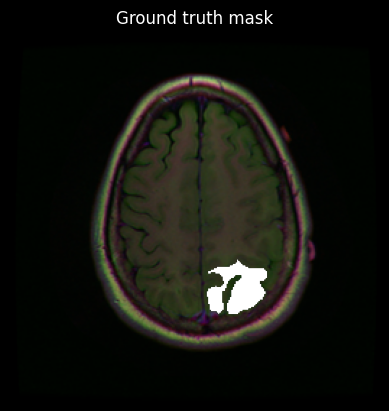

In [51]:
fig, axes = plt.subplots()

axes.imshow(np.array(img))
ground_truth_seg = np.array(example["mask"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [52]:
def get_bounding_box(ground_truth_map):
    if len(np.unique(ground_truth_map)) > 1:

        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(5, 20))
        x_max = min(W, x_max + np.random.randint(5, 20))
        y_min = max(0, y_min - np.random.randint(5, 20))
        y_max = min(H, y_max + np.random.randint(5, 20))

        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        return [0, 0, 256, 256]

In [53]:
class SAMDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["mask"])
    prompt = get_bounding_box(ground_truth_mask)
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    inputs["ground_truth_mask"] = ground_truth_mask/255

    return inputs

In [54]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base", do_normalize=False)

/trinity/home/hasaan.maqsood/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [55]:
train_sam_ds = SAMDataset(dataset=train_dataset, processor=processor)

In [56]:
exmpl = train_sam_ds[10]
for k,v in exmpl.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [57]:
train_dataloader = DataLoader(train_sam_ds, batch_size=CFG.TRAIN_BATCH_SIZE, shuffle=False)

In [58]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [59]:
train_df.shape

(1224, 2)

# Modeling

# SAM Model along with integrating FeatUp for enhanced feature visualization.

In [ ]:
!git clone https://github.com/mhamilton723/FeatUp
import os
os.chdir("FeatUp/")

!pip install -e .
!pip install git+https://github.com/mhamilton723/CLIP.git

fatal: destination path 'FeatUp' already exists and is not an empty directory.
Obtaining file:///content/FeatUp
  Preparing metadata (setup.py) ... done
  Using cached timm-0.4.12-py3-none-any.whl (376 kB)
  Attempting uninstall: timm
    Found existing installation: timm 0.9.2
    Uninstalling timm-0.9.2:
      Successfully uninstalled timm-0.9.2
  Attempting uninstall: featup
    Found existing installation: featup 0.1.2
    Uninstalling featup-0.1.2:
      Successfully uninstalled featup-0.1.2
  Running setup.py develop for featup
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segmentation-models-pytorch 0.3.3 requires timm==0.9.2, but you have timm 0.4.12 which is incompatible.
  Cloning https://github.com/mhamilton723/CLIP.git to /tmp/pip-req-build-sqnkkm0f
  Running command git clone --filter=blob:none --quiet https://github.com/mhamilton723/CLIP.git /tm

## Import Necessary Libraries

In [60]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import Adam
import monai
from tqdm.notebook import tqdm
from featup.util import norm, unnorm
from featup.plotting import plot_feats, plot_lang_heatmaps

## Initialize FeatUp Model

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_norm = True
upsampler = torch.hub.load("mhamilton723/FeatUp", 'dino16', use_norm=use_norm).to(device)

Using cache found in /trinity/home/hasaan.maqsood/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /trinity/home/hasaan.maqsood/.cache/torch/hub/facebookresearch_dino_main


## Load and Setup SAM Model

In [61]:
model = SamModel.from_pretrained("facebook/sam-vit-base")
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

optimizer = Adam(model.mask_decoder.parameters(), lr=CFG.LEARNING_RATE, weight_decay=CFG.WEIGHT_DECAY)
seg_loss = monai.losses.FocalLoss(reduction='mean')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/trinity/home/hasaan.maqsood/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

## Training Loop

In [37]:
import os
import json
import torch
import numpy as np
from tqdm import tqdm
from monai.metrics import DiceMetric
from monai.losses import FocalLoss
from monai.transforms import AsDiscrete, Activations
from torch.optim import Adam
import matplotlib.pyplot as plt

dice_metric = DiceMetric(include_background=False, reduction="mean")

def compute_accuracy(y_pred, y_true):
    correct = (y_pred == y_true).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy.item()

def compute_precision(y_pred, y_true):
    tp = (y_pred * y_true).sum().float()
    fp = (y_pred * (1 - y_true)).sum().float()
    precision = tp / (tp + fp + 1e-8)
    return precision.item()

def compute_recall(y_pred, y_true):
    tp = (y_pred * y_true).sum().float()
    fn = ((1 - y_pred) * y_true).sum().float()
    recall = tp / (tp + fn + 1e-8)
    return recall.item()

def compute_f1(y_pred, y_true):
    precision = compute_precision(y_pred, y_true)
    recall = compute_recall(y_pred, y_true)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1

num_epochs = CFG.EPOCH
model.train()
epoch_metrics = {
    "losses": [],
    "ious": [],
    "accuracies": [],
    "precisions": [],
    "recalls": [],
    "f1s": [],
    "dice_scores": []
}

save_dir = "model_checkpoints"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    print(f'EPOCH: {epoch}')
    batch_losses = []
    batch_ious = []
    batch_accuracies = []
    batch_precisions = []
    batch_recalls = []
    batch_f1s = []
    batch_dice_scores = []

    for i, batch in enumerate(tqdm(train_dataloader)):
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].unsqueeze(1).float().to(device)

        sam_masks_prob = torch.sigmoid(predicted_masks)
        sam_masks_prob = sam_masks_prob.squeeze()
        sam_masks = (sam_masks_prob > 0.5)

        loss = seg_loss(predicted_masks, ground_truth_masks)
        batch_losses.append(loss.item())
        ious = compute_iou(sam_masks.unsqueeze(1), ground_truth_masks, ignore_empty=False)
        batch_ious.append(ious.mean().item())

        outputs = Activations(sigmoid=True)(predicted_masks)
        outputs = AsDiscrete(threshold=0.5)(outputs)

        dice_metric(y_pred=outputs, y=ground_truth_masks)

        accuracy = compute_accuracy(outputs, ground_truth_masks)
        precision = compute_precision(outputs, ground_truth_masks)
        recall = compute_recall(outputs, ground_truth_masks)
        f1 = compute_f1(outputs, ground_truth_masks)
        dice_score = dice_metric.aggregate().item()

        batch_accuracies.append(accuracy)
        batch_precisions.append(precision)
        batch_recalls.append(recall)
        batch_f1s.append(f1)
        batch_dice_scores.append(dice_score)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    mean_loss = np.mean(batch_losses)
    epoch_metrics["losses"].append(mean_loss)
    print(f'Mean loss: {mean_loss}')

    mean_iou = np.mean(batch_ious)
    epoch_metrics["ious"].append(mean_iou)
    print(f'Mean IoU: {mean_iou}')

    mean_accuracy = np.mean(batch_accuracies)
    epoch_metrics["accuracies"].append(mean_accuracy)
    print(f'Mean Accuracy: {mean_accuracy}')

    mean_precision = np.mean(batch_precisions)
    epoch_metrics["precisions"].append(mean_precision)
    print(f'Mean Precision: {mean_precision}')

    mean_recall = np.mean(batch_recalls)
    epoch_metrics["recalls"].append(mean_recall)
    print(f'Mean Recall: {mean_recall}')

    mean_f1 = np.mean(batch_f1s)
    epoch_metrics["f1s"].append(mean_f1)
    print(f'Mean F1 Score: {mean_f1}')

    mean_dice_score = np.mean(batch_dice_scores)
    epoch_metrics["dice_scores"].append(mean_dice_score)
    print(f'Mean Dice Score: {mean_dice_score}')

    model_save_path = os.path.join(save_dir, f"sam_featup_epoch_{epoch}.pth")
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    dice_metric.reset()


EPOCH: 0


100%|█████████████████████████████████████████| 612/612 [02:57<00:00,  3.45it/s]


Mean loss: 0.016157001109140944
Mean IoU: 0.5143316119229341
Mean Accuracy: 0.9837937448538986
Mean Precision: 0.7626701605421022
Mean Recall: 0.6948438100639489
Mean F1 Score: 0.683963604084737
Mean Dice Score: 0.4972153315381482
Model saved to model_checkpoints/sam_featup_epoch_0.pth
EPOCH: 1


100%|█████████████████████████████████████████| 612/612 [02:55<00:00,  3.49it/s]


Mean loss: 0.006076922225617512
Mean IoU: 0.6316209853127648
Mean Accuracy: 0.9901828516542522
Mean Precision: 0.8316575342338849
Mean Recall: 0.808495313050895
Mean F1 Score: 0.801803655169195
Mean Dice Score: 0.7313740895269742
Model saved to model_checkpoints/sam_featup_epoch_1.pth
EPOCH: 2


100%|█████████████████████████████████████████| 612/612 [02:57<00:00,  3.45it/s]


Mean loss: 0.005786506703836399
Mean IoU: 0.6440786326218859
Mean Accuracy: 0.9907261592889923
Mean Precision: 0.8385497016552227
Mean Recall: 0.8165334402123204
Mean F1 Score: 0.8089284799335508
Mean Dice Score: 0.7466969928320717
Model saved to model_checkpoints/sam_featup_epoch_2.pth
EPOCH: 3


100%|█████████████████████████████████████████| 612/612 [02:55<00:00,  3.49it/s]


Mean loss: 0.005425209517923969
Mean IoU: 0.6598566462836697
Mean Accuracy: 0.9913406621396931
Mean Precision: 0.8472879025476431
Mean Recall: 0.8270128509680302
Mean F1 Score: 0.8223409007706016
Mean Dice Score: 0.752083376342175
Model saved to model_checkpoints/sam_featup_epoch_3.pth
EPOCH: 4


100%|█████████████████████████████████████████| 612/612 [02:57<00:00,  3.46it/s]


Mean loss: 0.005224615143436263
Mean IoU: 0.6699882670384801
Mean Accuracy: 0.9916272381551905
Mean Precision: 0.8509064281688017
Mean Recall: 0.83338056101762
Mean F1 Score: 0.8294273377415274
Mean Dice Score: 0.762546460807713
Model saved to model_checkpoints/sam_featup_epoch_4.pth
EPOCH: 5


100%|█████████████████████████████████████████| 612/612 [02:54<00:00,  3.50it/s]


Mean loss: 0.0051203951772395215
Mean IoU: 0.6756305648987881
Mean Accuracy: 0.9919095506855086
Mean Precision: 0.8556091420936818
Mean Recall: 0.8374081299962853
Mean F1 Score: 0.8339121561151115
Mean Dice Score: 0.7650761729946324
Model saved to model_checkpoints/sam_featup_epoch_5.pth
EPOCH: 6


100%|█████████████████████████████████████████| 612/612 [02:54<00:00,  3.50it/s]


Mean loss: 0.005023590391109929
Mean IoU: 0.6809565460163296
Mean Accuracy: 0.9920366449293747
Mean Precision: 0.8562007811334398
Mean Recall: 0.8398234308225535
Mean F1 Score: 0.8368887406893193
Mean Dice Score: 0.7708775397219689
Model saved to model_checkpoints/sam_featup_epoch_6.pth
EPOCH: 7


100%|█████████████████████████████████████████| 612/612 [02:55<00:00,  3.48it/s]


Mean loss: 0.005069455207596393
Mean IoU: 0.6748426515073364
Mean Accuracy: 0.991904988008387
Mean Precision: 0.8541669028938985
Mean Recall: 0.8339923485334403
Mean F1 Score: 0.8327570420412123
Mean Dice Score: 0.7697735527177262
Model saved to model_checkpoints/sam_featup_epoch_7.pth
EPOCH: 8


100%|█████████████████████████████████████████| 612/612 [02:54<00:00,  3.50it/s]


Mean loss: 0.004886784269211942
Mean IoU: 0.6844370343716316
Mean Accuracy: 0.9922354953740936
Mean Precision: 0.8614570017830998
Mean Recall: 0.8401641098879813
Mean F1 Score: 0.8390748411226274
Mean Dice Score: 0.7753490285546172
Model saved to model_checkpoints/sam_featup_epoch_8.pth
EPOCH: 9


100%|█████████████████████████████████████████| 612/612 [02:54<00:00,  3.51it/s]


Mean loss: 0.005171037348309909
Mean IoU: 0.6757249731412218
Mean Accuracy: 0.9918665169111265
Mean Precision: 0.8609549558532783
Mean Recall: 0.8344112927751506
Mean F1 Score: 0.8348859524318398
Mean Dice Score: 0.7786837825977725
Model saved to model_checkpoints/sam_featup_epoch_9.pth


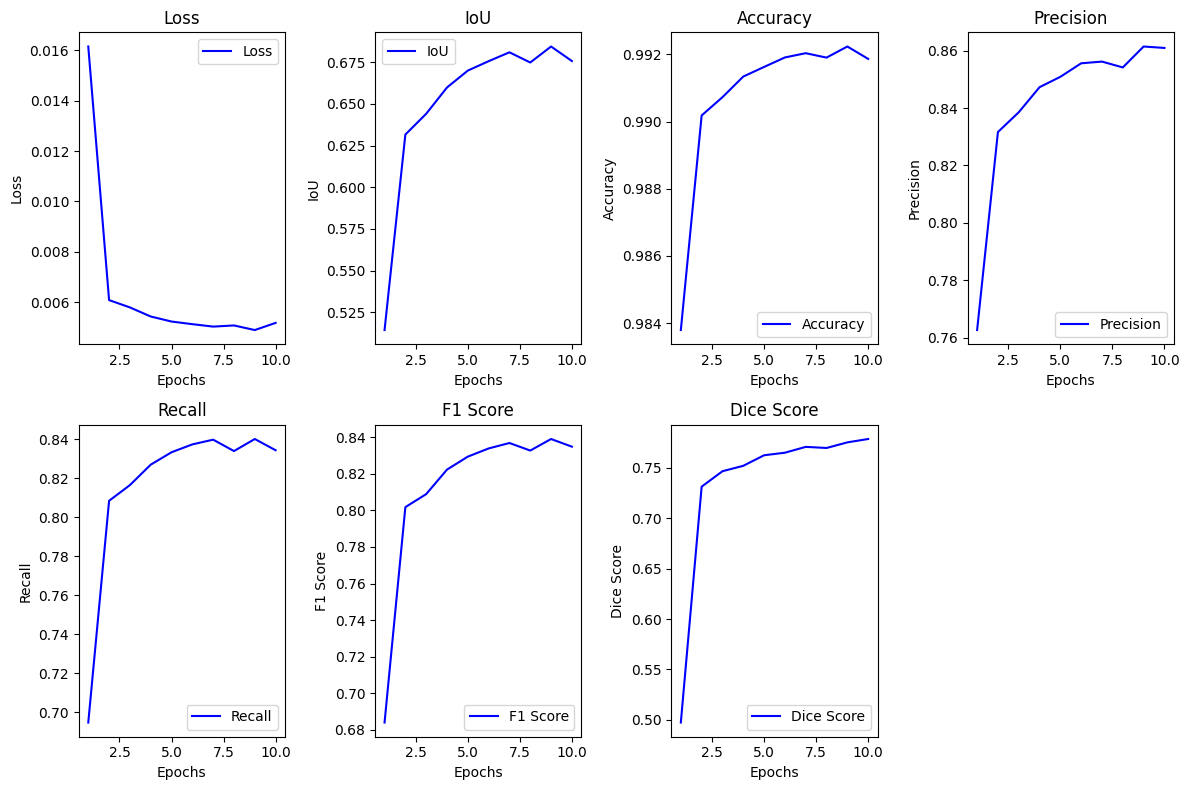

Final Dice Score: 0.7786837825977725


In [38]:
with open('training_metrics.json', 'w') as f:
    json.dump(epoch_metrics, f, indent=4)

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 4, 1)
plt.plot(epochs, epoch_metrics["losses"], 'b', label='Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 4, 2)
plt.plot(epochs, epoch_metrics["ious"], 'b', label='IoU')
plt.title('IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.subplot(2, 4, 3)
plt.plot(epochs, epoch_metrics["accuracies"], 'b', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 4, 4)
plt.plot(epochs, epoch_metrics["precisions"], 'b', label='Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 4, 5)
plt.plot(epochs, epoch_metrics["recalls"], 'b', label='Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 4, 6)
plt.plot(epochs, epoch_metrics["f1s"], 'b', label='F1 Score')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(2, 4, 7)
plt.plot(epochs, epoch_metrics["dice_scores"], 'b', label='Dice Score')
plt.title('Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

final_dice_score = epoch_metrics["dice_scores"][-1]

print(f'Final Dice Score: {final_dice_score}')

## Inference with DataLoader

  0%|                                                    | 0/34 [00:00<?, ?it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.8183],
        [0.9119],
        [0.0000],
        [0.8559]], device='cuda:0')


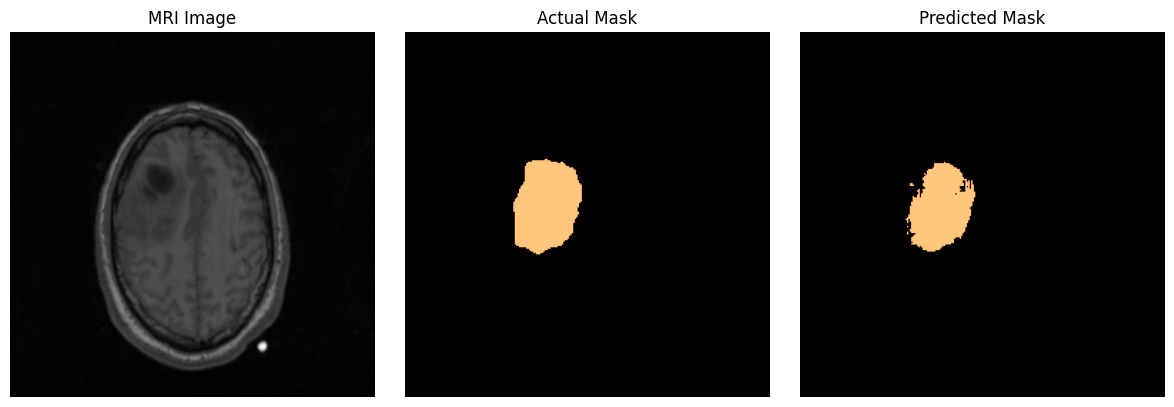

  3%|█▎                                          | 1/34 [00:00<00:31,  1.06it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.1743],
        [0.6500],
        [0.8943],
        [0.5661]], device='cuda:0')


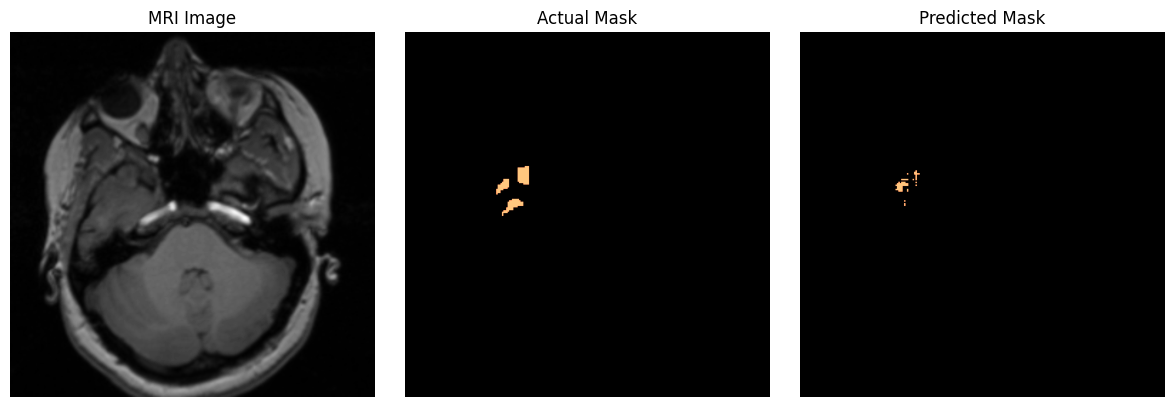

  6%|██▌                                         | 2/34 [00:01<00:28,  1.14it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.7341],
        [0.7244],
        [0.3059],
        [0.7423]], device='cuda:0')


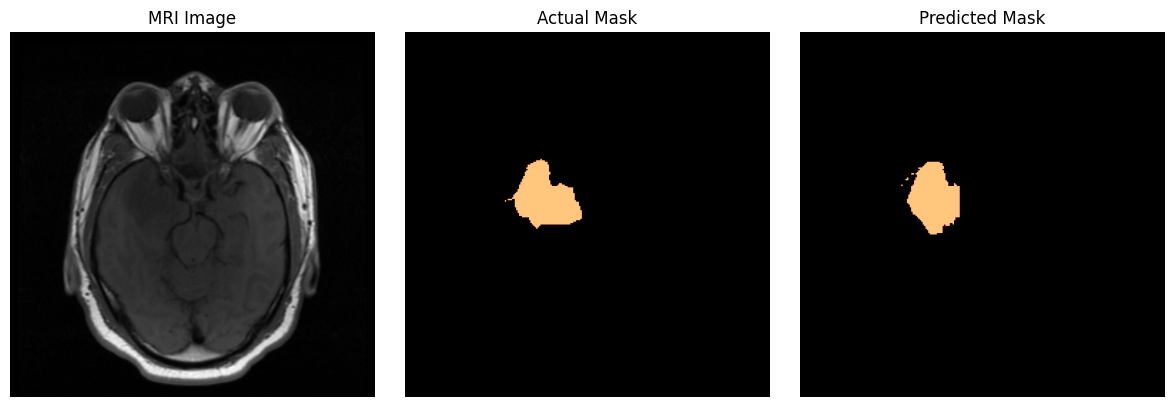

  9%|███▉                                        | 3/34 [00:02<00:26,  1.17it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.8844],
        [0.2463],
        [0.1481],
        [0.3812]], device='cuda:0')


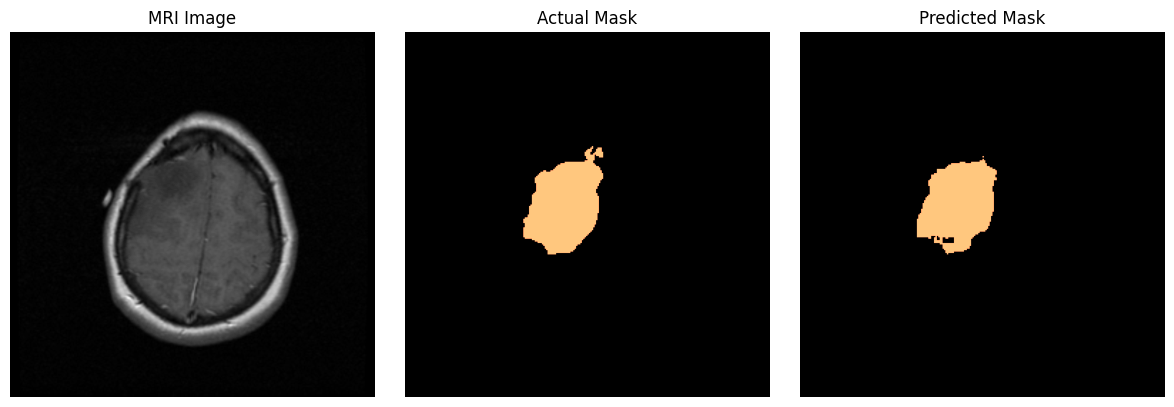

 12%|█████▏                                      | 4/34 [00:03<00:25,  1.18it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.4217],
        [0.0332],
        [0.7400],
        [0.6263]], device='cuda:0')


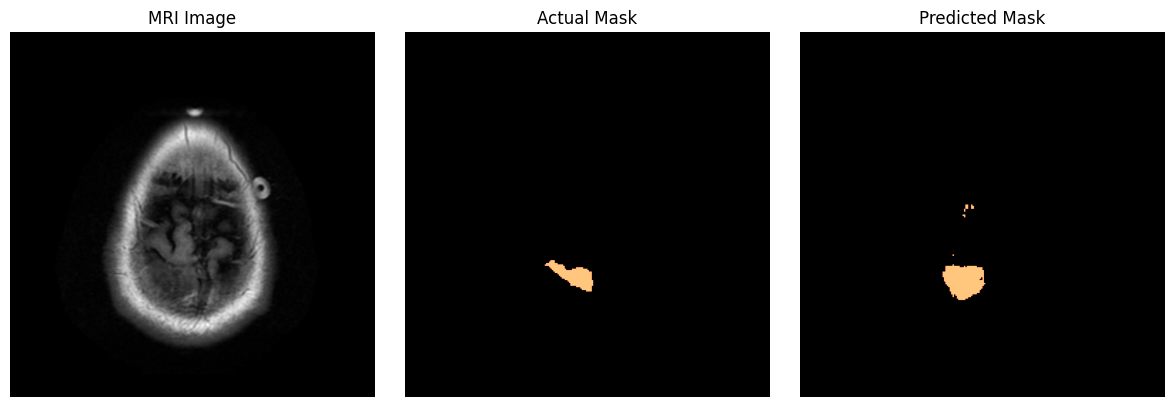

 15%|██████▍                                     | 5/34 [00:04<00:24,  1.19it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.7930],
        [0.8859],
        [0.7832],
        [0.6525]], device='cuda:0')


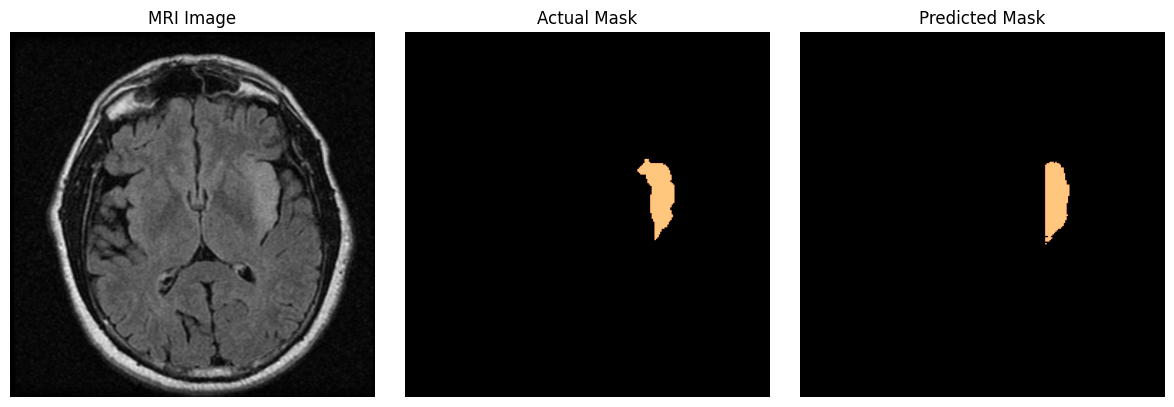

 18%|███████▊                                    | 6/34 [00:05<00:23,  1.19it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.4940],
        [0.4456],
        [0.8768],
        [0.9279]], device='cuda:0')


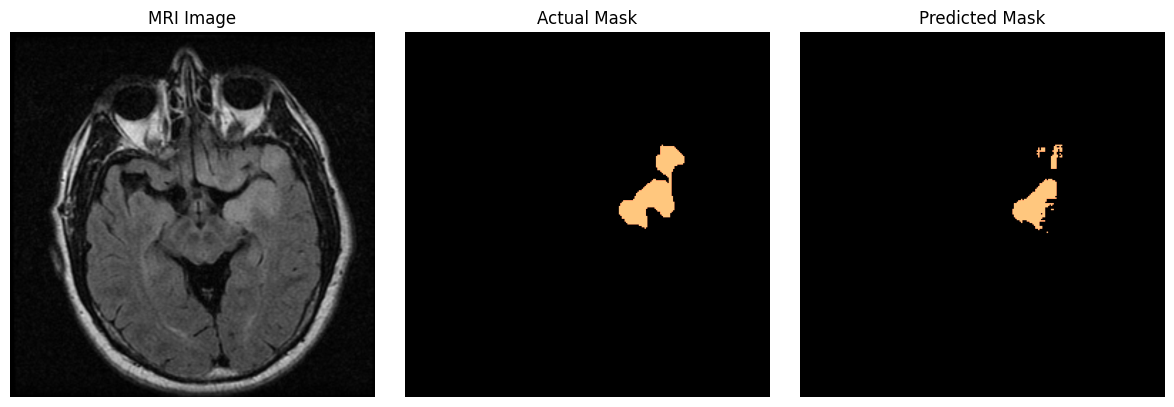

 21%|█████████                                   | 7/34 [00:06<00:25,  1.07it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.3891],
        [0.5426],
        [0.6862],
        [0.7091]], device='cuda:0')


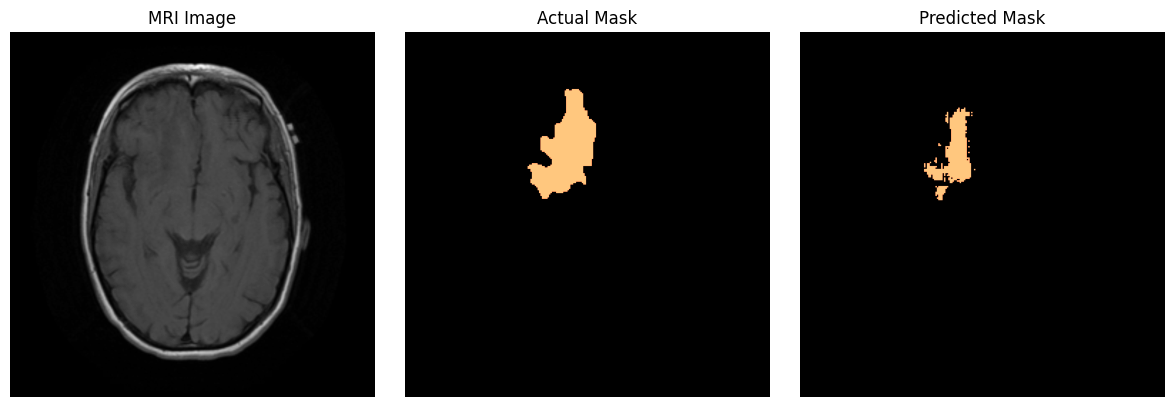

 24%|██████████▎                                 | 8/34 [00:07<00:23,  1.11it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.7830],
        [0.3966],
        [0.6508],
        [0.0852]], device='cuda:0')


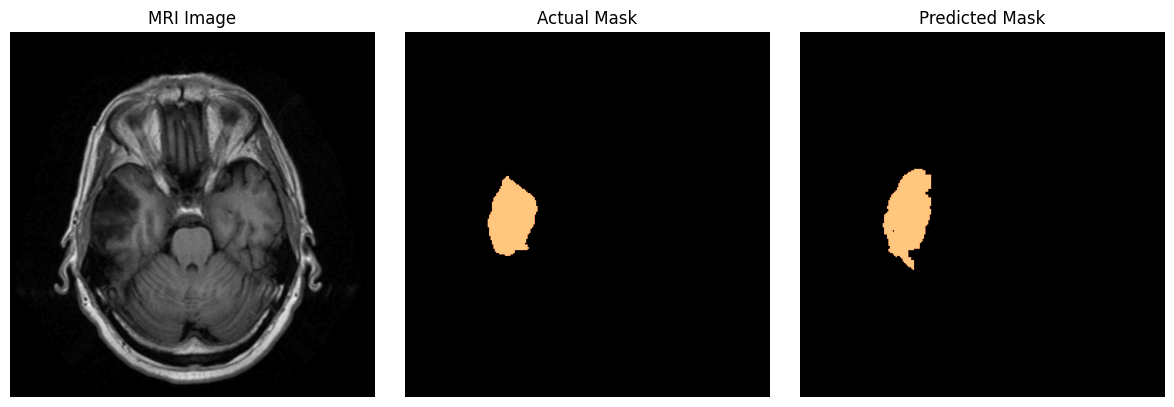

 26%|███████████▋                                | 9/34 [00:07<00:21,  1.14it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.8493],
        [0.4932],
        [0.3220],
        [0.9113]], device='cuda:0')


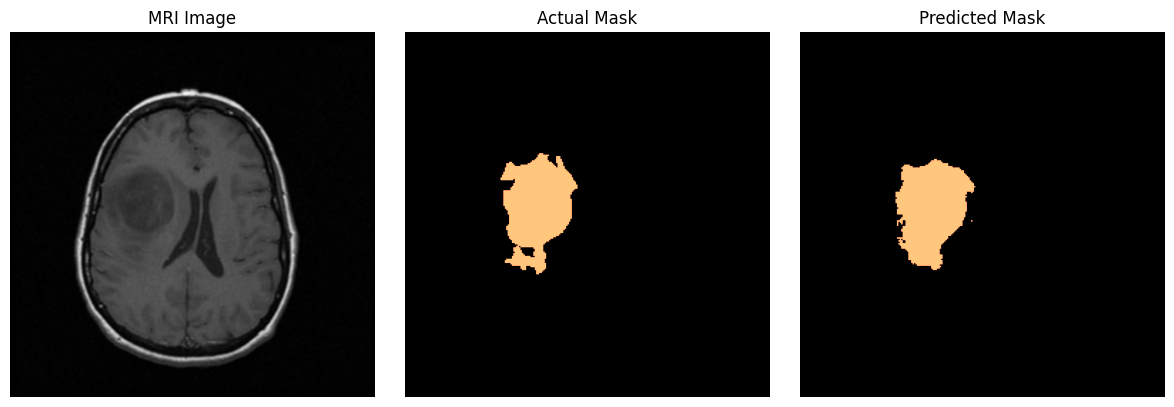

 29%|████████████▋                              | 10/34 [00:08<00:20,  1.16it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.8403],
        [0.8137],
        [0.6565],
        [0.6285]], device='cuda:0')


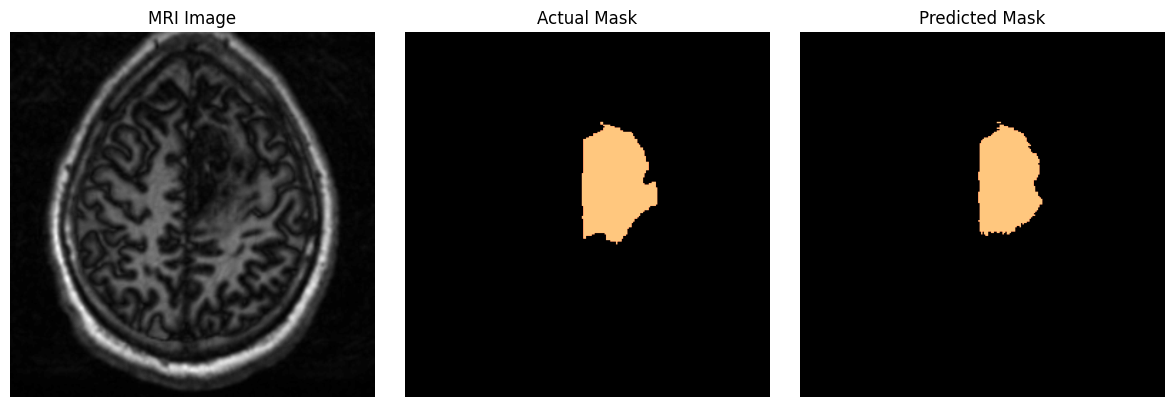

 32%|█████████████▉                             | 11/34 [00:09<00:19,  1.17it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.7845],
        [0.8176],
        [0.7747],
        [0.4304]], device='cuda:0')


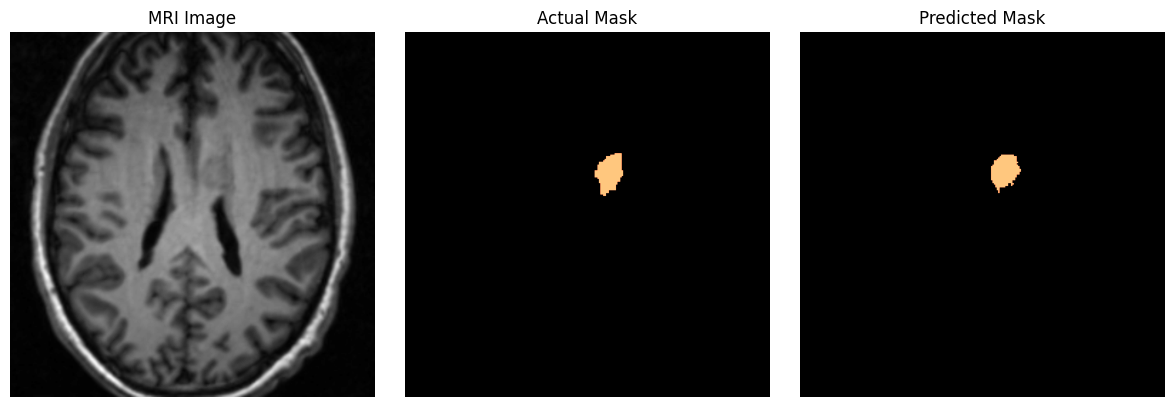

 35%|███████████████▏                           | 12/34 [00:10<00:18,  1.18it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.6685],
        [0.4982],
        [0.8807],
        [0.7680]], device='cuda:0')


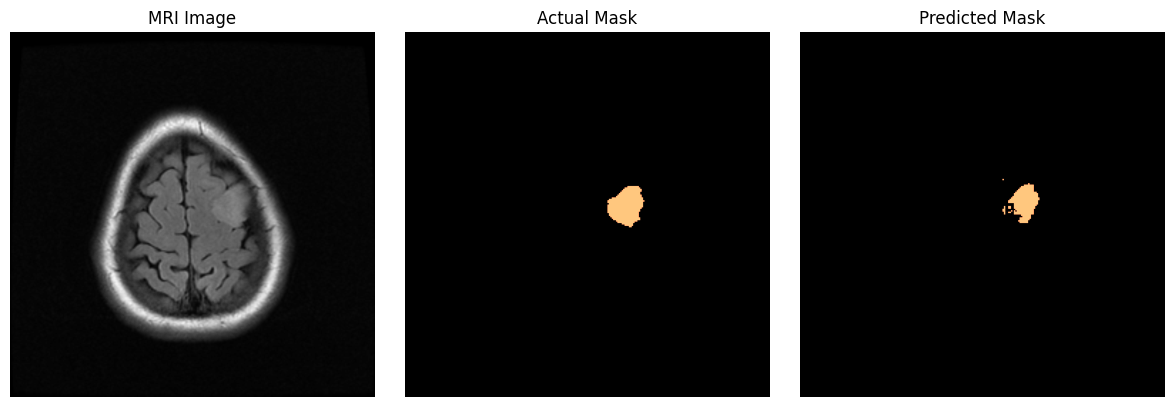

 38%|████████████████▍                          | 13/34 [00:11<00:17,  1.19it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.7760],
        [0.5557],
        [0.3476],
        [0.8539]], device='cuda:0')


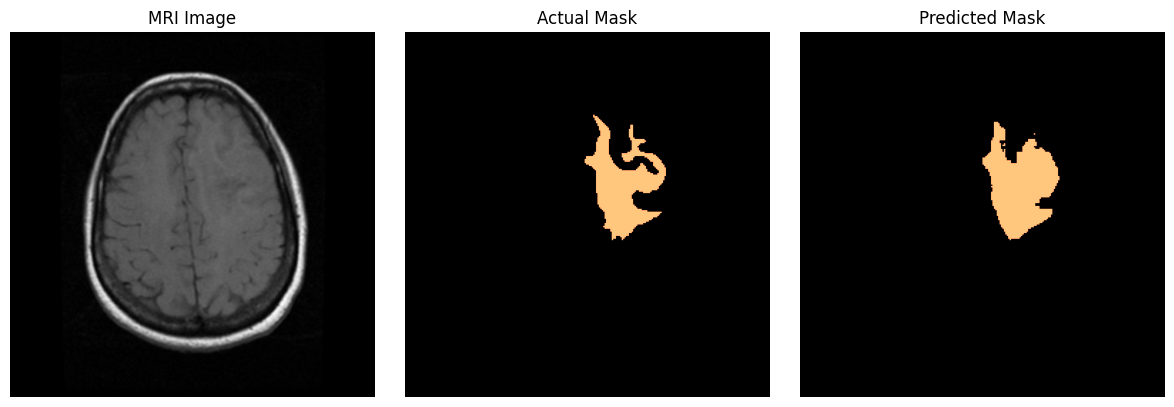

 41%|█████████████████▋                         | 14/34 [00:12<00:16,  1.19it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.3053],
        [0.6733],
        [0.9463],
        [0.9474]], device='cuda:0')


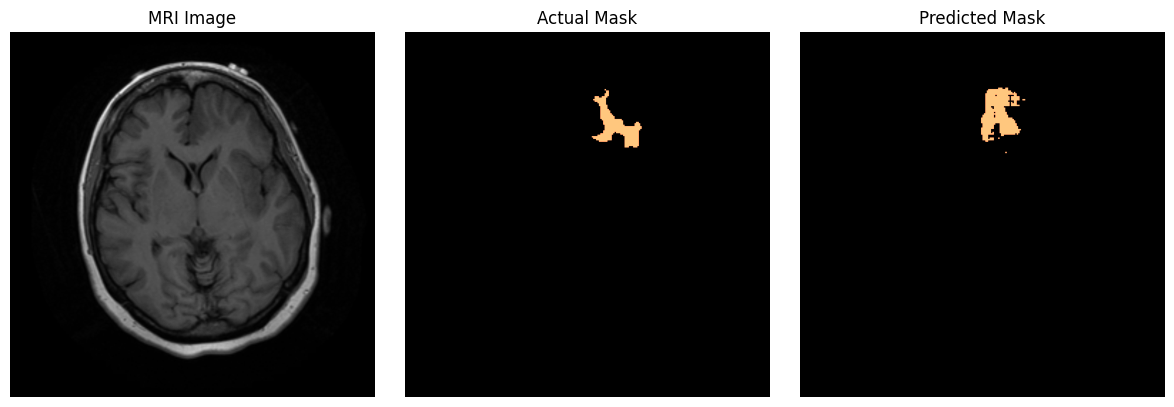

 44%|██████████████████▉                        | 15/34 [00:12<00:15,  1.20it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.6797],
        [0.9006],
        [0.8285],
        [0.8689]], device='cuda:0')


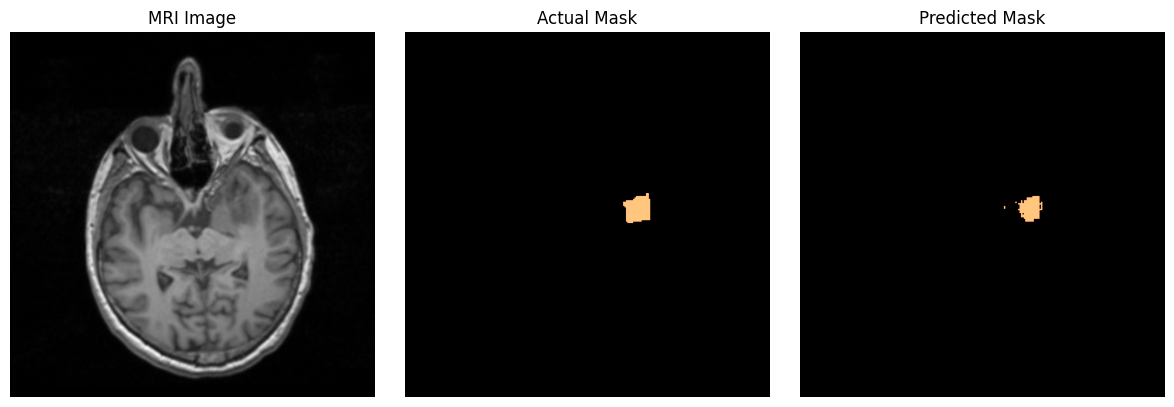

 47%|████████████████████▏                      | 16/34 [00:13<00:14,  1.20it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.5623],
        [0.9048],
        [0.0000],
        [0.6746]], device='cuda:0')


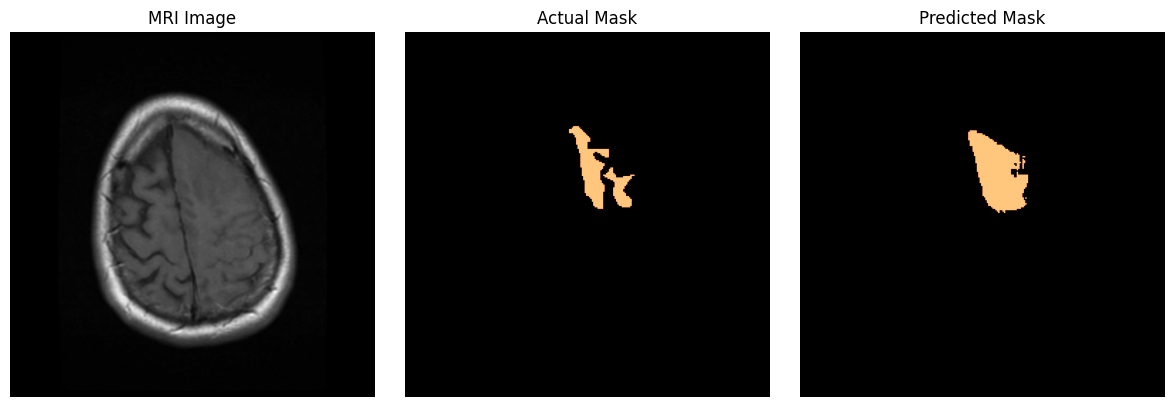

 50%|█████████████████████▌                     | 17/34 [00:14<00:14,  1.21it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.6267],
        [0.4710],
        [0.7465],
        [0.4578]], device='cuda:0')


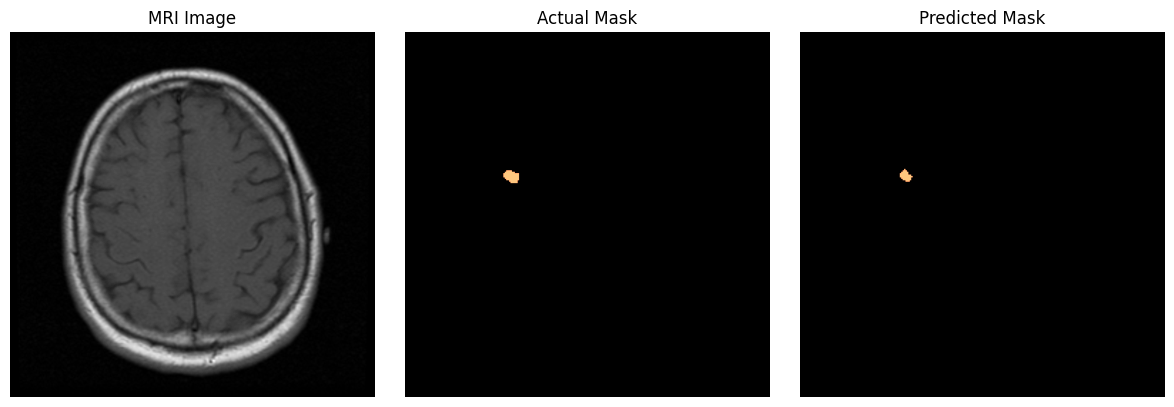

 53%|██████████████████████▊                    | 18/34 [00:15<00:13,  1.20it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.6952],
        [0.7948],
        [0.7614],
        [0.9017]], device='cuda:0')


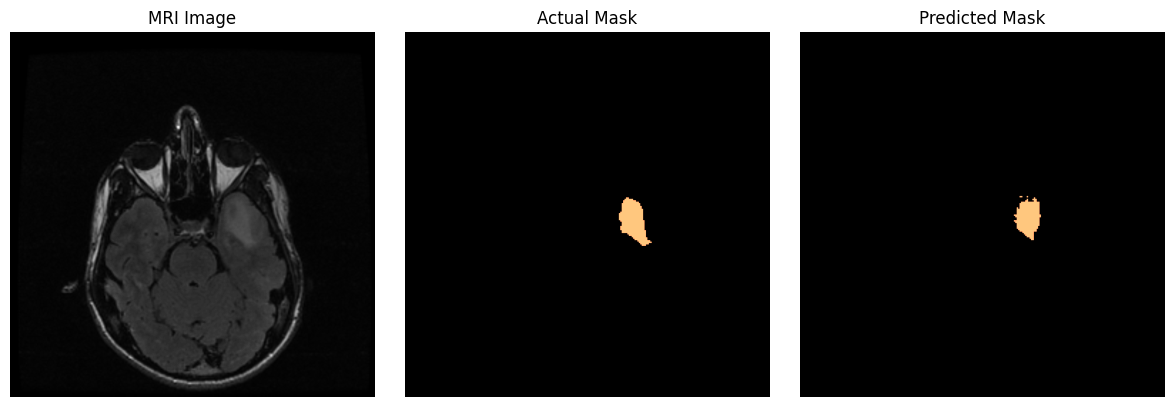

 56%|████████████████████████                   | 19/34 [00:16<00:12,  1.20it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.9141],
        [0.8156],
        [0.9168],
        [0.6579]], device='cuda:0')


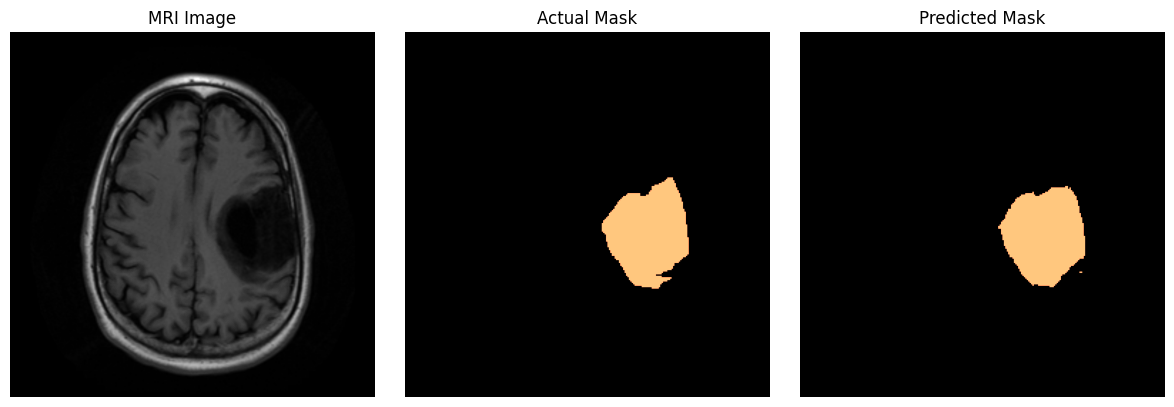

 59%|█████████████████████████▎                 | 20/34 [00:17<00:11,  1.21it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.8491],
        [0.9355],
        [0.8950],
        [0.6347]], device='cuda:0')


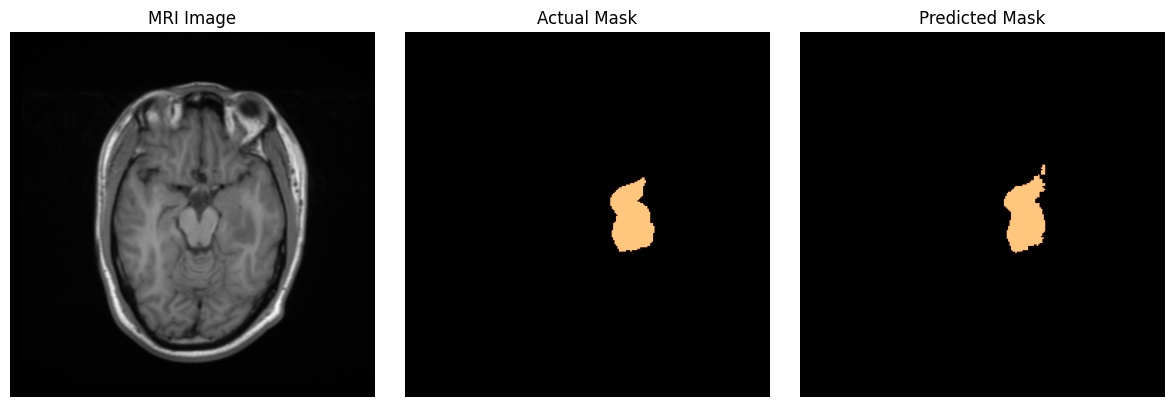

 62%|██████████████████████████▌                | 21/34 [00:17<00:10,  1.21it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.4444],
        [0.4410],
        [0.5018],
        [0.2391]], device='cuda:0')


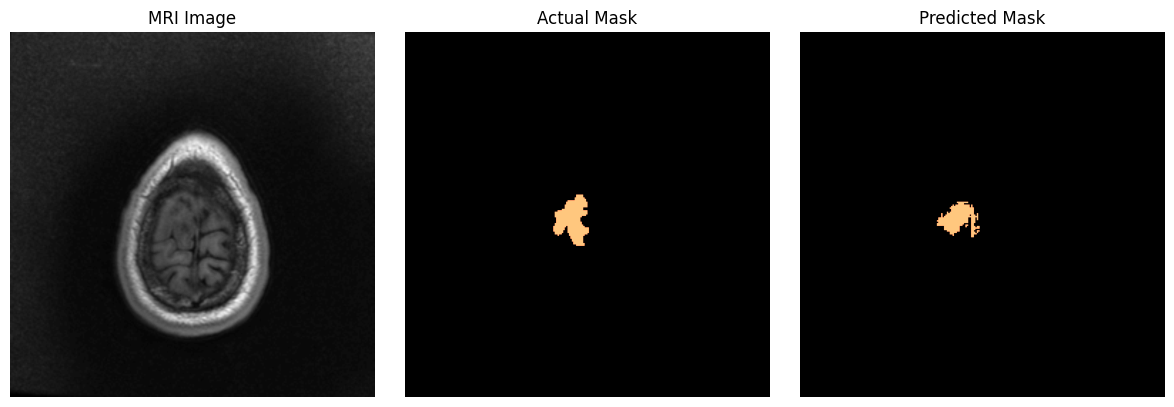

 65%|███████████████████████████▊               | 22/34 [00:18<00:09,  1.20it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.6845],
        [0.5043],
        [0.5842],
        [0.8306]], device='cuda:0')


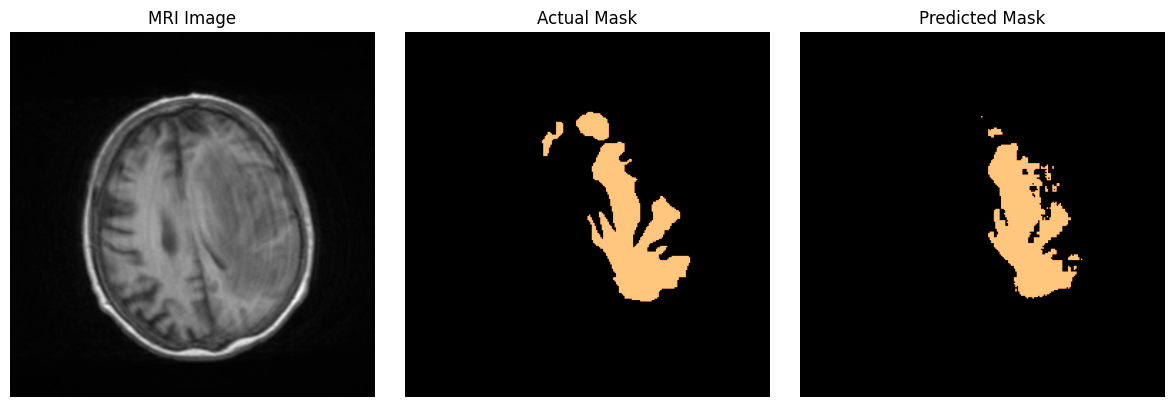

 68%|█████████████████████████████              | 23/34 [00:19<00:09,  1.20it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.9264],
        [0.8149],
        [0.9124],
        [0.9139]], device='cuda:0')


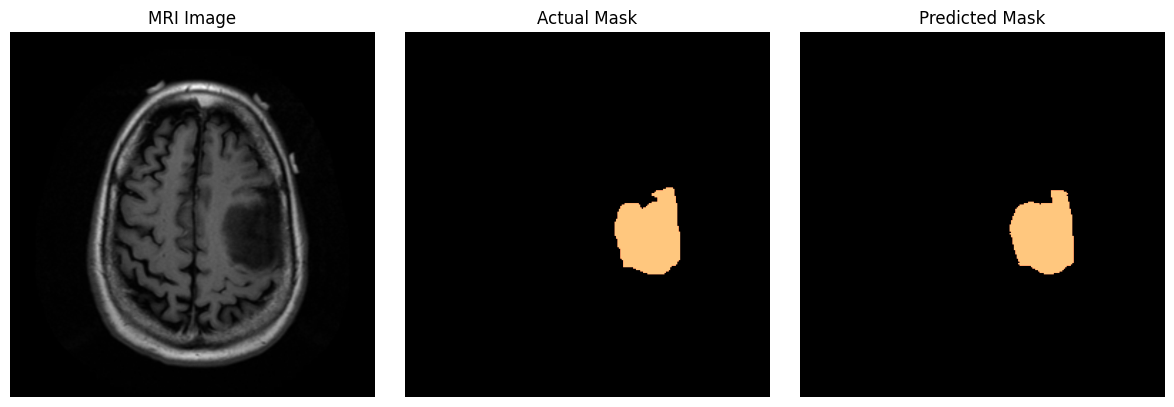

 71%|██████████████████████████████▎            | 24/34 [00:20<00:08,  1.21it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.8559],
        [0.6871],
        [0.4314],
        [0.9020]], device='cuda:0')


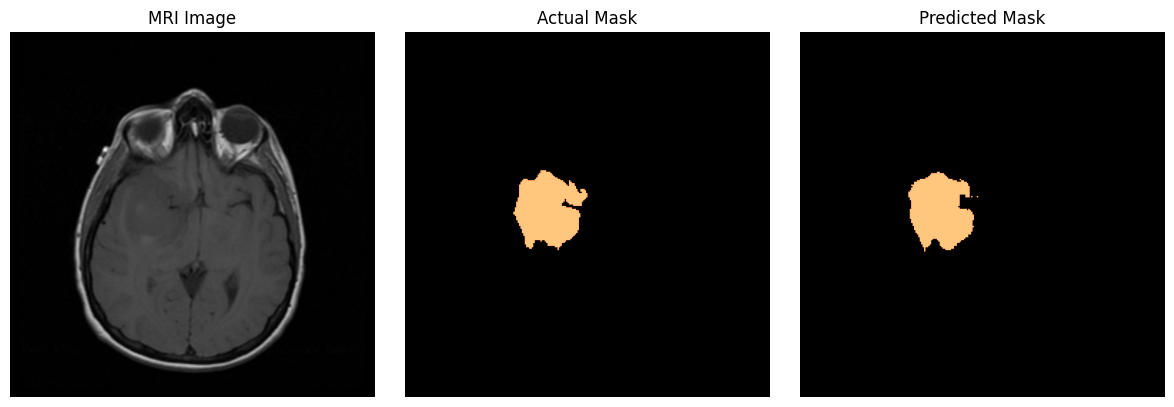

 74%|███████████████████████████████▌           | 25/34 [00:21<00:07,  1.21it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.2886],
        [0.9300],
        [0.6256],
        [0.8818]], device='cuda:0')


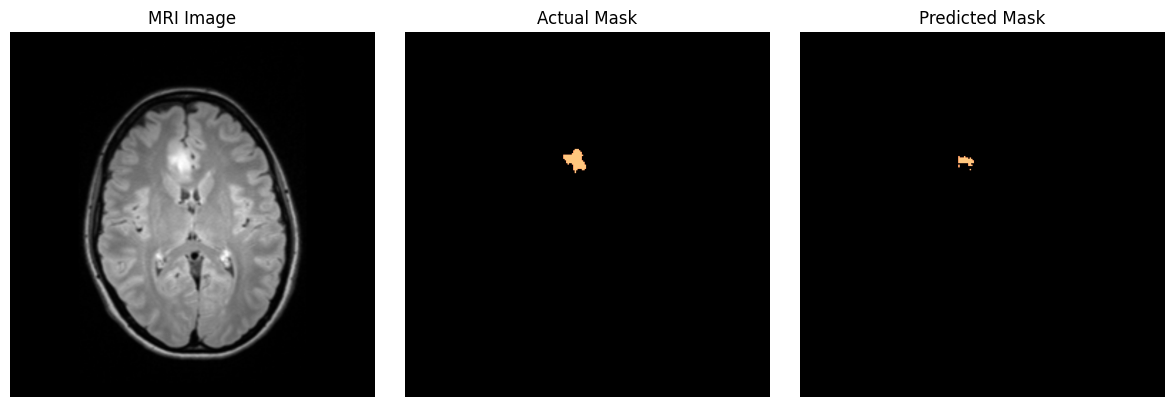

 76%|████████████████████████████████▉          | 26/34 [00:21<00:06,  1.21it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.9346],
        [0.4534],
        [0.8229],
        [0.8400]], device='cuda:0')


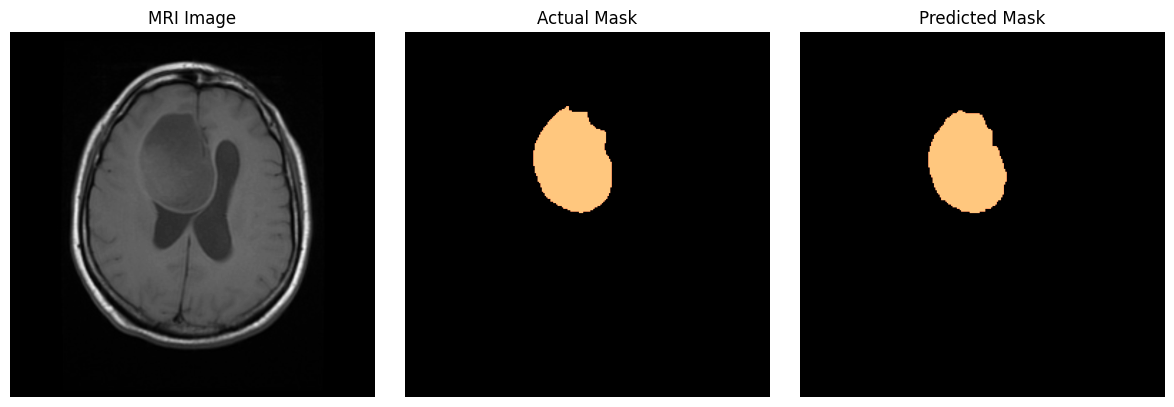

 79%|██████████████████████████████████▏        | 27/34 [00:22<00:05,  1.21it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.1071],
        [0.8498],
        [0.9056],
        [0.8942]], device='cuda:0')


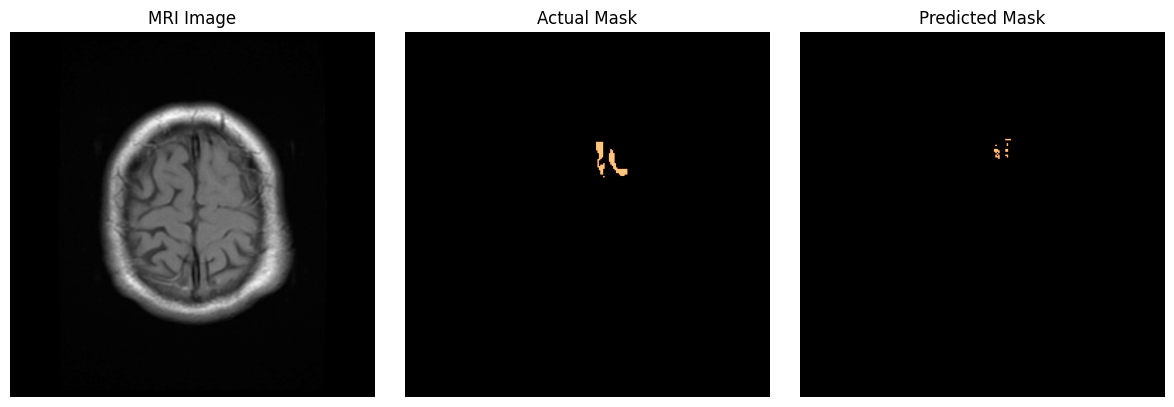

 82%|███████████████████████████████████▍       | 28/34 [00:23<00:04,  1.21it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.9116],
        [0.9309],
        [0.7936],
        [0.9355]], device='cuda:0')


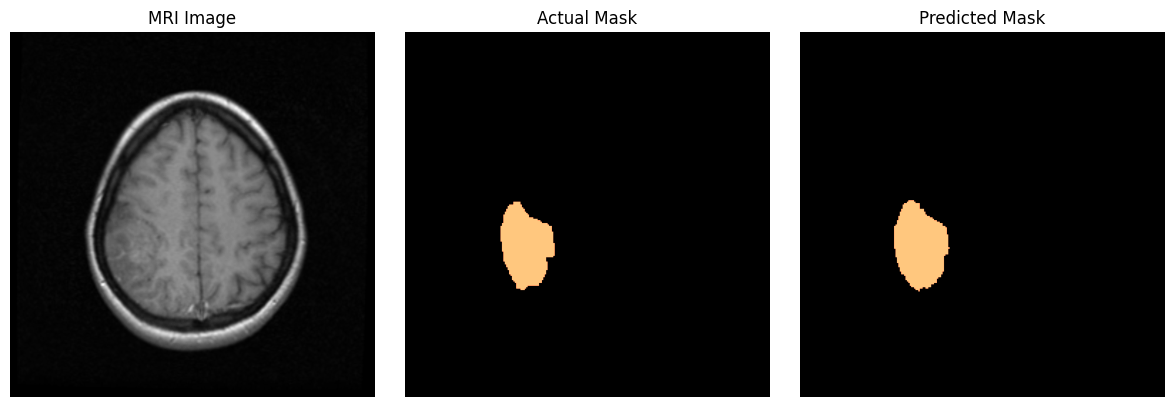

 85%|████████████████████████████████████▋      | 29/34 [00:24<00:04,  1.18it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.0000],
        [0.2791],
        [0.9430],
        [0.6575]], device='cuda:0')


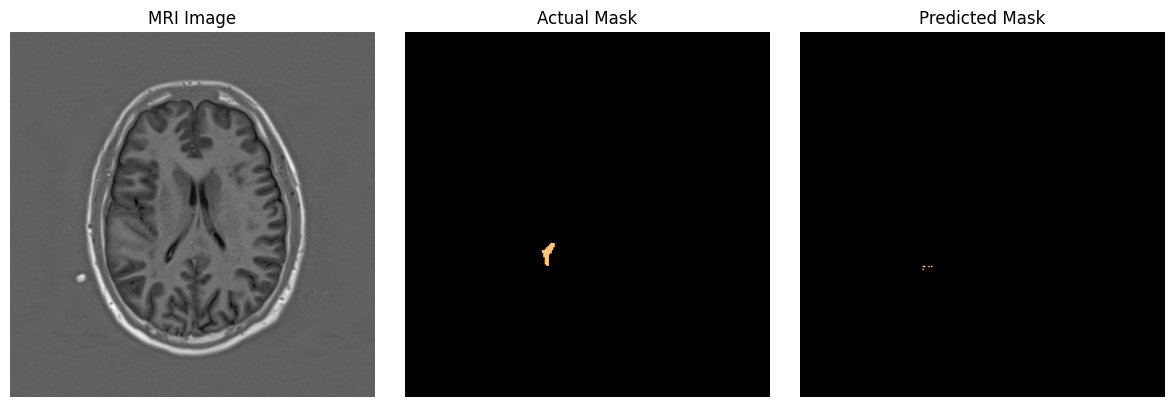

 88%|█████████████████████████████████████▉     | 30/34 [00:25<00:03,  1.19it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.9289],
        [0.7734],
        [0.8741],
        [0.4079]], device='cuda:0')


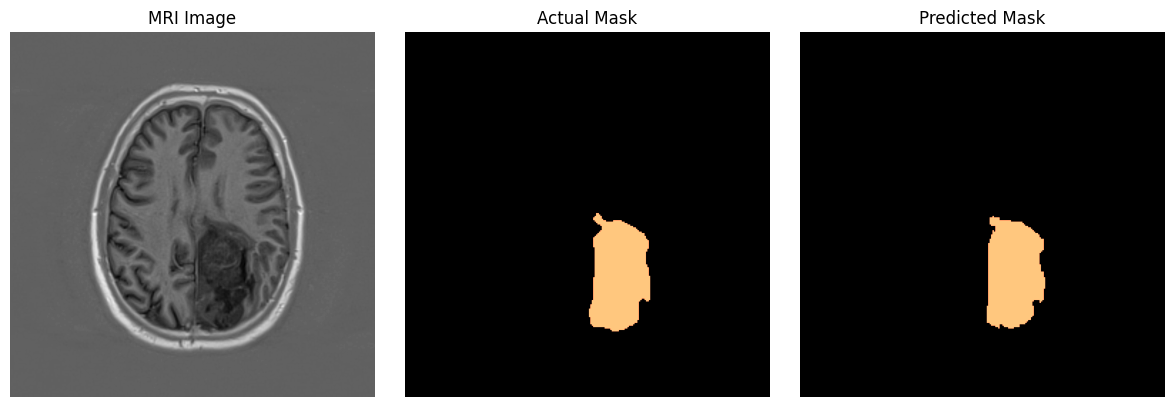

 91%|███████████████████████████████████████▏   | 31/34 [00:26<00:02,  1.07it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.8506],
        [0.5762],
        [0.6640],
        [0.8196]], device='cuda:0')


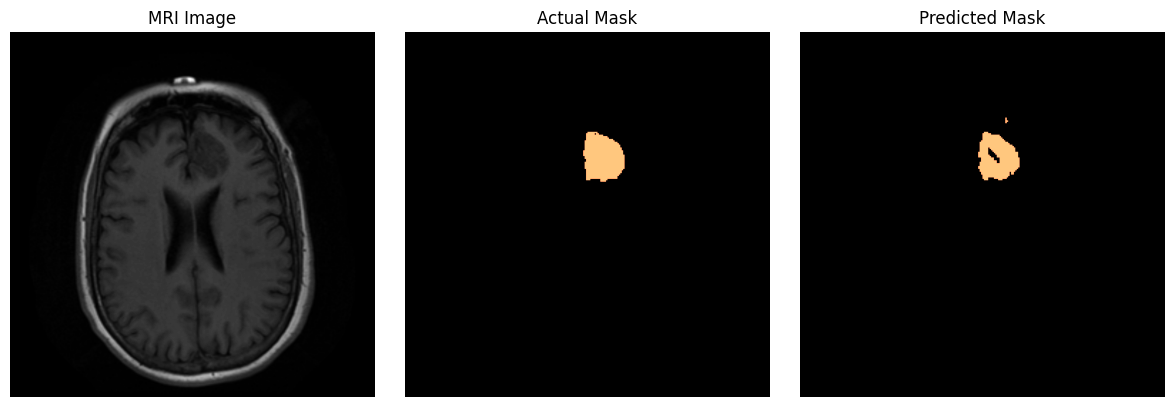

 94%|████████████████████████████████████████▍  | 32/34 [00:27<00:01,  1.11it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.6265],
        [0.7191],
        [0.6624],
        [0.8259]], device='cuda:0')


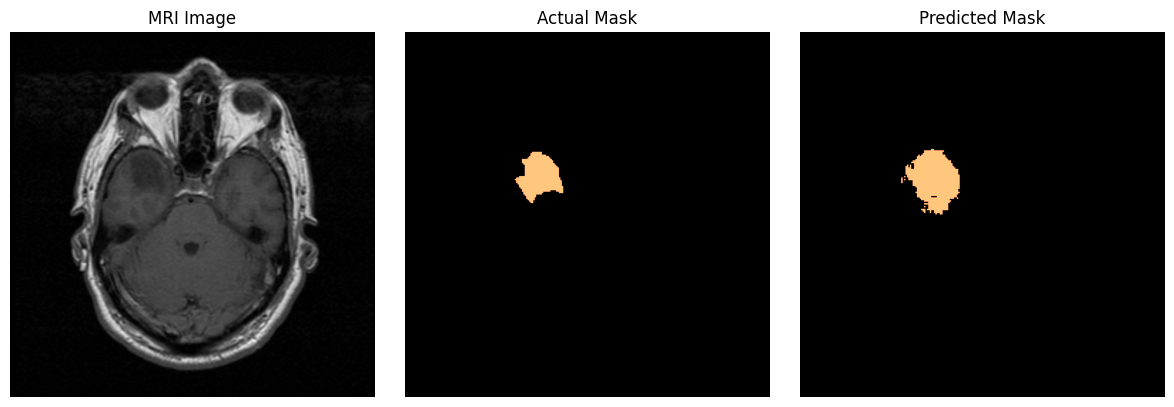

 97%|█████████████████████████████████████████▋ | 33/34 [00:28<00:00,  1.13it/s]

sam_mask_tensor shape: torch.Size([4, 1, 256, 256])
ground_truth_masks_tensor shape: torch.Size([4, 1, 256, 256])
IoU: tensor([[0.8143],
        [0.0000],
        [0.6014],
        [0.9302]], device='cuda:0')


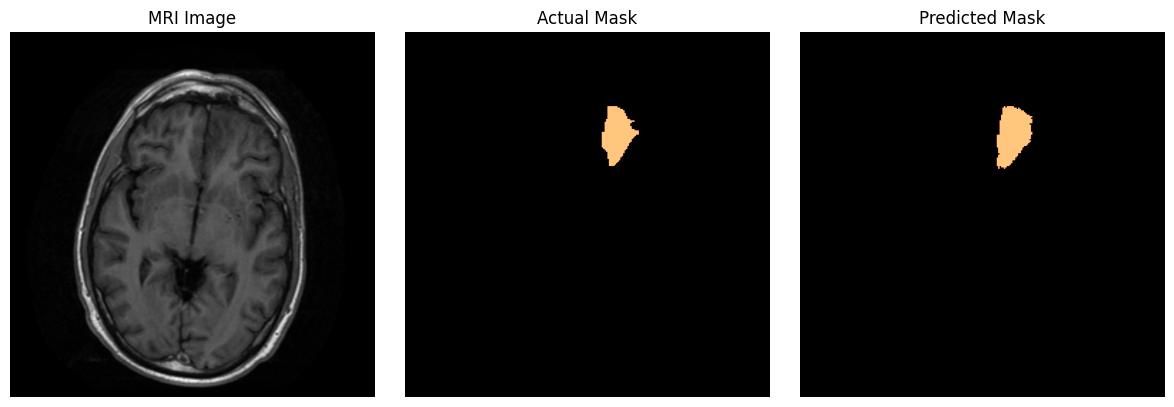

100%|███████████████████████████████████████████| 34/34 [00:28<00:00,  1.17it/s]

Mean IoU on test set: 0.6671308506937588


In [39]:
class CFG:
    TEST_BATCH_SIZE = 4  
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

test_sam_ds = SAMDataset(test_dataset, processor=processor)
test_dataloader = DataLoader(test_sam_ds, batch_size=CFG.TEST_BATCH_SIZE, shuffle=False)

test_ious = []
model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        outputs = model(pixel_values=batch["pixel_values"].to(CFG.DEVICE),
                        input_boxes=batch["input_boxes"].to(CFG.DEVICE),
                        multimask_output=False)

        ground_truth_masks = batch["ground_truth_mask"].float().to(CFG.DEVICE)

        sam_mask_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        sam_mask_prob = sam_mask_prob.cpu().numpy()
        sam_mask = (sam_mask_prob > 0.5)
        sam_mask_tensor = torch.from_numpy(sam_mask).float().to(CFG.DEVICE).squeeze(1).unsqueeze(1)
        ground_truth_masks_tensor = ground_truth_masks.unsqueeze(1).to(CFG.DEVICE)

        print(f'sam_mask_tensor shape: {sam_mask_tensor.shape}')
        print(f'ground_truth_masks_tensor shape: {ground_truth_masks_tensor.shape}')

        try:
            iou = compute_iou(sam_mask_tensor, ground_truth_masks_tensor, ignore_empty=False)
        except ValueError as e:
            print(f"Error computing IoU: {e}")
            continue

        print(f'IoU: {iou}')
        test_ious.append(iou.mean().item())

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(batch["pixel_values"][0, 0].cpu(), cmap='gray')  
        plt.title('MRI Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(batch["ground_truth_mask"][0].cpu(), cmap='copper')
        plt.title('Actual Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(sam_mask[0, 0], cmap='copper')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

mean_test_iou = np.mean(test_ious)
print(f'Mean IoU on test set: {mean_test_iou}')

## FeatUp Integration and Visualization

/trinity/home/hasaan.maqsood/.local/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Seed set to 0


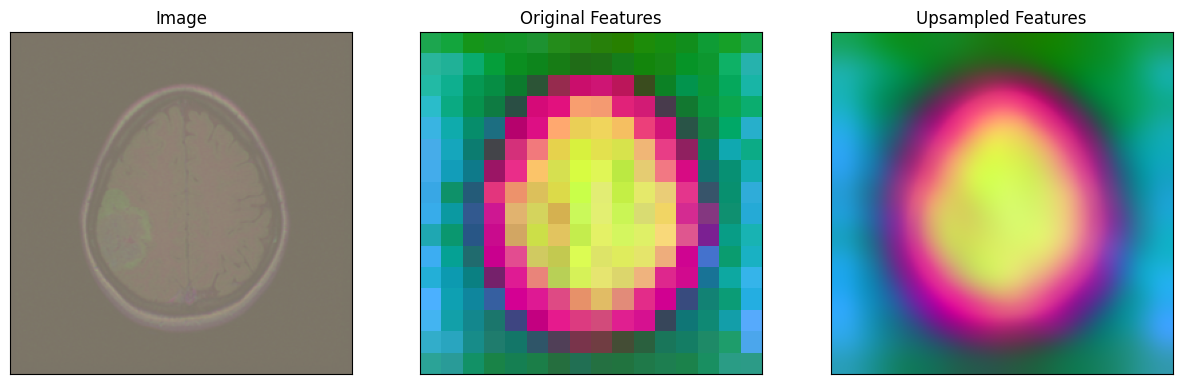

In [40]:
def visualize_featup(image_tensor):
    hr_feats = upsampler(image_tensor)
    lr_feats = upsampler.model(image_tensor)
    plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

image = test_dataset[-1]["image"]
transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
image_tensor = transform(image).unsqueeze(0).to(device)
visualize_featup(image_tensor)


In [ ]:
test_df['image_path'][0]

'/content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_23.tif'

In [ ]:
len(unnorm(image_tensor)[0].shape)

3

## PCA of upsampled features

In [41]:
from featup.util import pca
image = test_dataset[-1]["image"]
print(type(image))
transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
image_tensor = transform(image).unsqueeze(0).to(device)

hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)

image, lr, hr = unnorm(image_tensor)[0], lr_feats[0], hr_feats[0]
print(hr.shape)
[lr_feats_pca, hr_feats_pca], _ = pca([lr.unsqueeze(0), hr.unsqueeze(0)])
new = hr_feats_pca[0]
new.shape

<class 'PIL.PngImagePlugin.PngImageFile'>
torch.Size([384, 256, 256])


torch.Size([3, 256, 256])

Visualizing with channel 0 and colormap jet


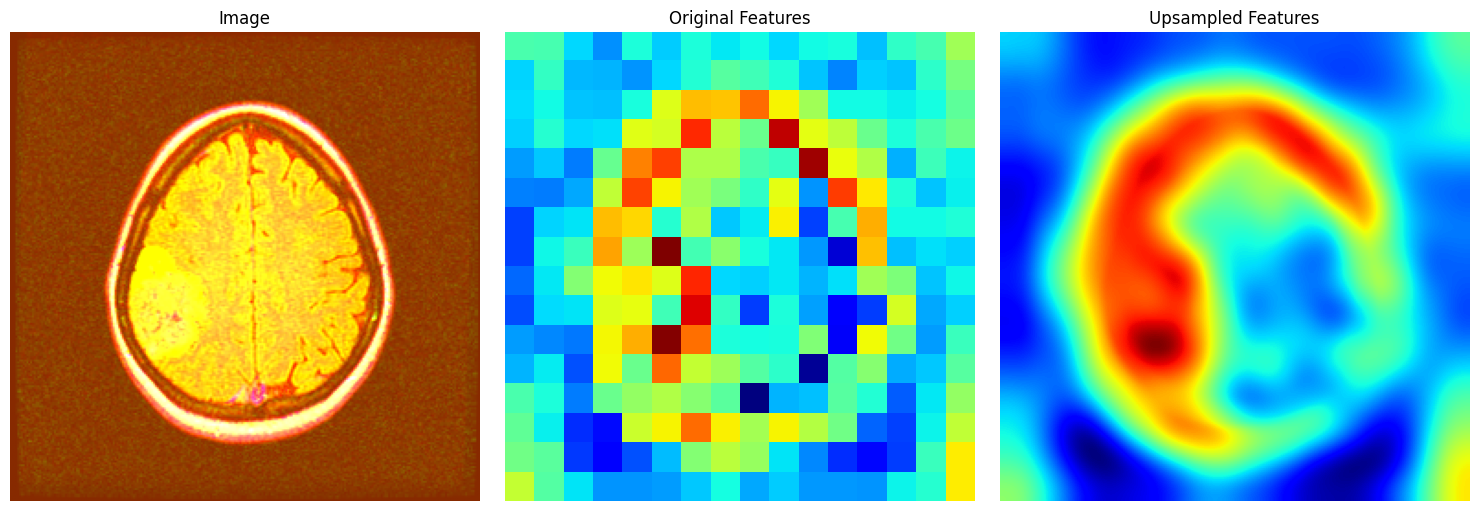

Visualizing with channel 1 and colormap viridis


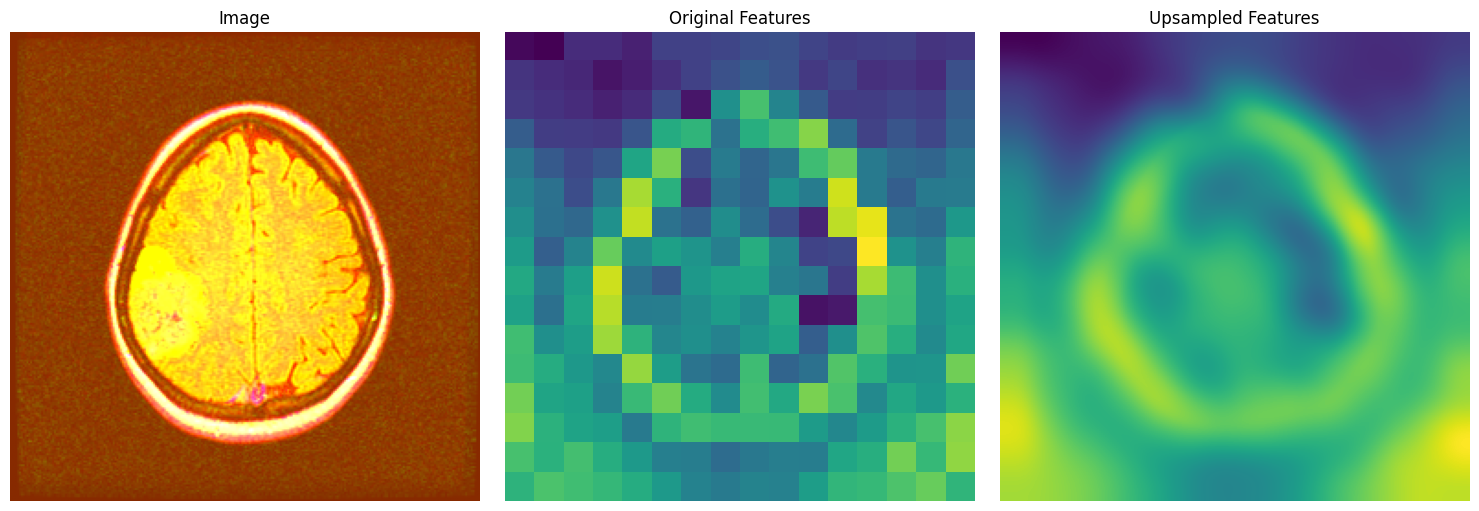

Visualizing with channel 2 and colormap plasma


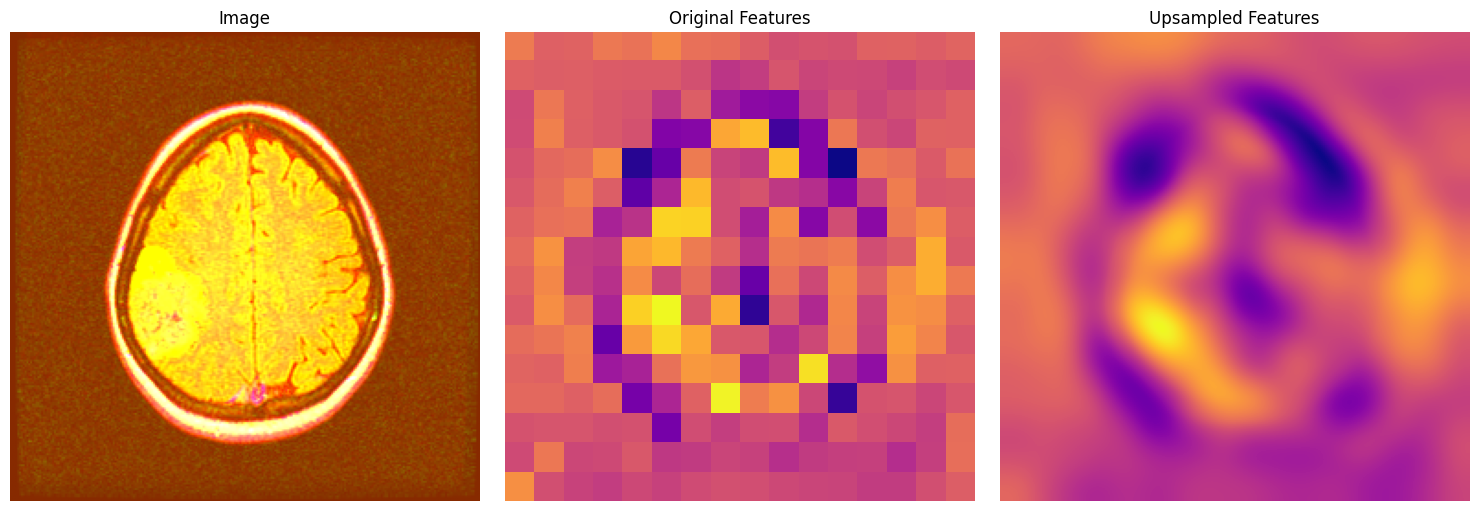

Visualizing with channel 3 and colormap inferno


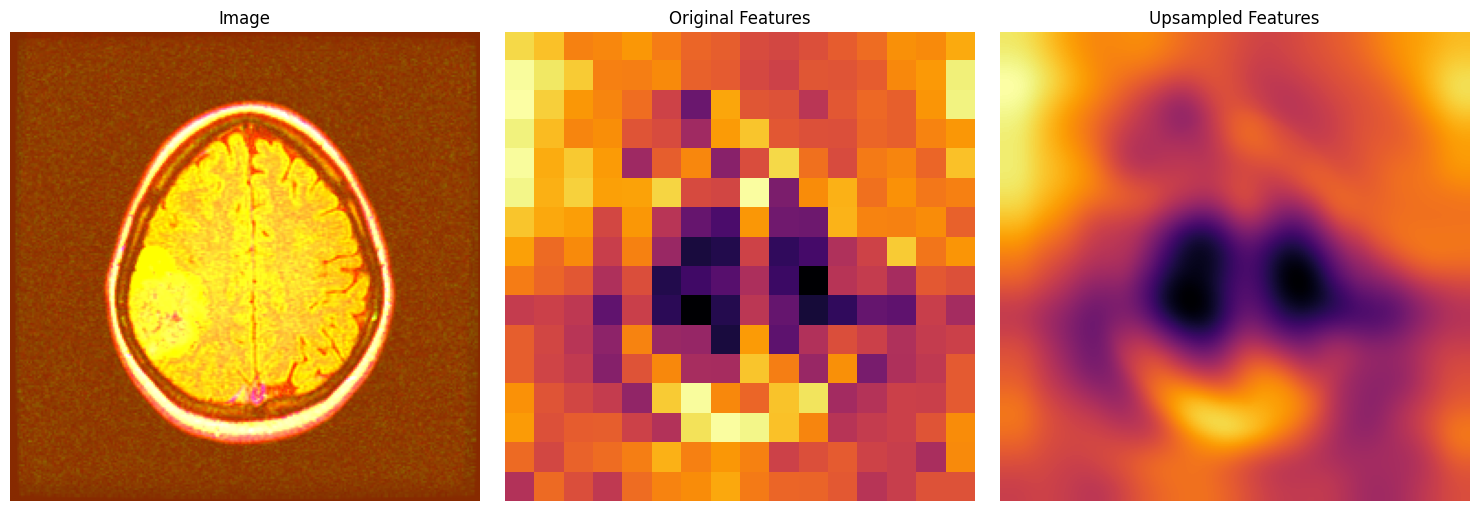

Visualizing with channel 4 and colormap magma


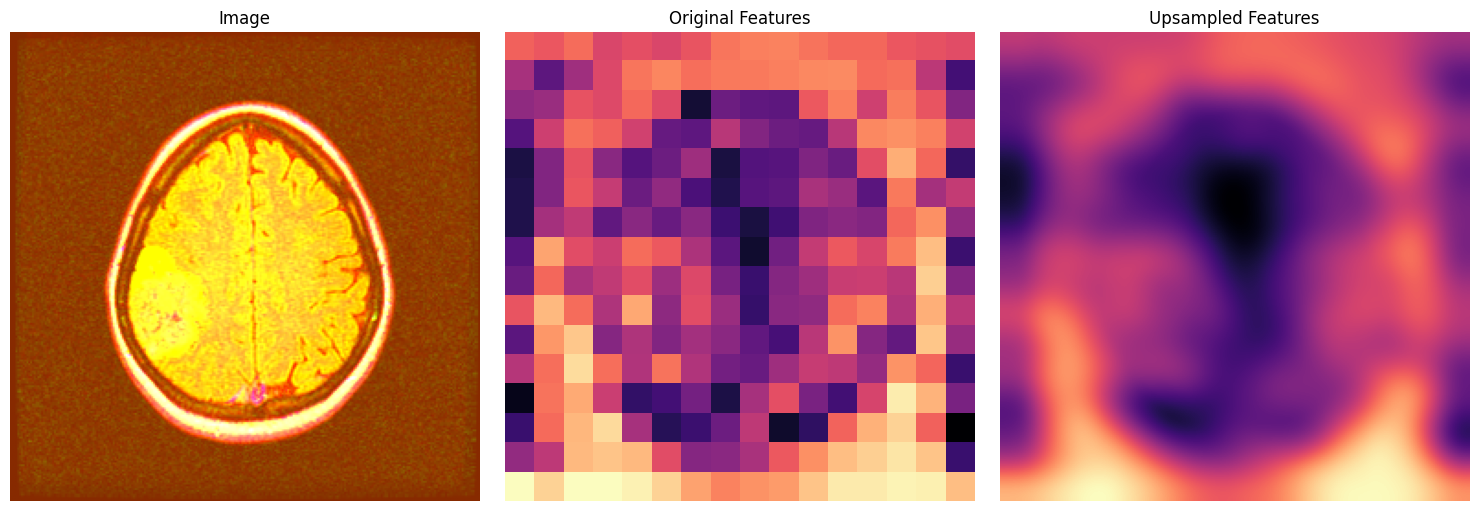

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image, ImageEnhance
from featup.util import norm, unnorm
from featup.plotting import plot_feats

def enhance_image(image_tensor):
    """Enhance the image contrast and brightness for better visualization."""
    image = unnorm(image_tensor)[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  
    image_pil = Image.fromarray((image * 255).astype(np.uint8))
    enhancer = ImageEnhance.Contrast(image_pil)
    image_pil = enhancer.enhance(2)  
    enhancer = ImageEnhance.Brightness(image_pil)
    image_pil = enhancer.enhance(1.5)  
    return np.array(image_pil) / 255.0  

def visualize_featup(image_tensor, channel=0, cmap='jet'):
    hr_feats = upsampler(image_tensor)
    lr_feats = upsampler.model(image_tensor)

    image = enhance_image(image_tensor)
    lr_feat_img = lr_feats[0].cpu().detach().numpy().squeeze()
    hr_feat_img = hr_feats[0].cpu().detach().numpy().squeeze()

    if len(lr_feat_img.shape) > 2:
        lr_feat_img = lr_feat_img[channel] 
    if len(hr_feat_img.shape) > 2:
        hr_feat_img = hr_feat_img[channel] 

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis('off')

    axes[1].imshow(lr_feat_img, cmap=cmap)
    axes[1].set_title("Original Features")
    axes[1].axis('off')

    axes[2].imshow(hr_feat_img, cmap=cmap)
    axes[2].set_title("Upsampled Features")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

image = test_dataset[-1]["image"]
transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
image_tensor = transform(image).unsqueeze(0).to(device)

settings = [
    {"channel": 0, "cmap": "jet"},
    {"channel": 1, "cmap": "viridis"},
    {"channel": 2, "cmap": "plasma"},
    {"channel": 3, "cmap": "inferno"},
    {"channel": 4, "cmap": "magma"}
]

for setting in settings:
    print(f"Visualizing with channel {setting['channel']} and colormap {setting['cmap']}")
    visualize_featup(image_tensor, channel=setting["channel"], cmap=setting["cmap"])


## Inference with Known Bounding Box

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


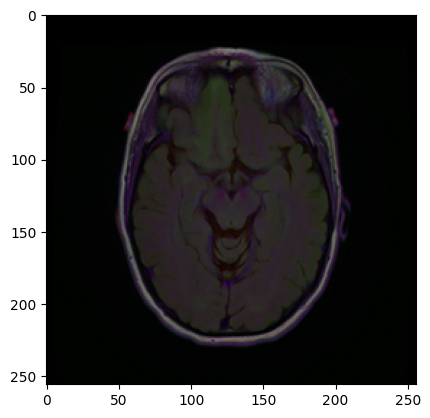

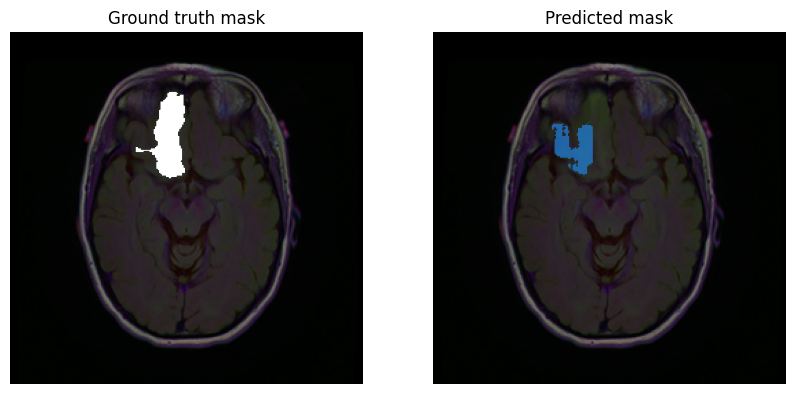

In [43]:
idx = 10
image = test_dataset[idx]["image"]
plt.imshow(np.array(image))

ground_truth_mask = np.array(test_dataset[idx]["mask"])
prompt = get_bounding_box(ground_truth_mask)
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

model.eval()
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(np.array(image))
show_mask(ground_truth_mask, axes[0])
axes[0].title.set_text("Ground truth mask")
axes[0].axis("off")

axes[1].imshow(np.array(image))
show_mask(medsam_seg, axes[1])
axes[1].title.set_text("Predicted mask")
axes[1].axis("off")

plt.show()


## Inference with Unknown Bounding Box

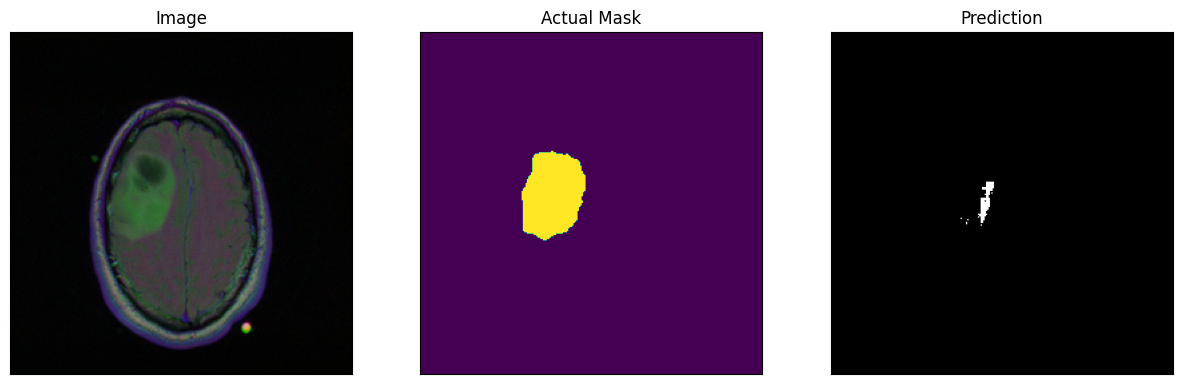

In [44]:
array_size = 256
grid_size = 10
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)
xv, yv = np.meshgrid(x, y)
xv_list = xv.tolist()
yv_list = yv.tolist()

input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

image = test_dataset[0]["image"]
ground_truth_mask = np.array(test_dataset[0]["mask"])

inputs = processor(image, input_points=input_points, return_tensors="pt").to(device)

model.eval()
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(np.array(image), cmap='gray')
axes[0].set_title("Image")
axes[1].imshow(ground_truth_mask)
axes[1].set_title("Actual Mask")
axes[2].imshow(medsam_seg, cmap='gray')
axes[2].set_title("Prediction")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()


## Evaluation

In [48]:
from monai.metrics import compute_iou
pred = torch.from_numpy(medsam_seg).float()
act = torch.from_numpy(ground_truth_mask).float()
iou = compute_iou(act/255, pred, ignore_empty=False)
print(f"IoU: {iou}")

IoU: 0.06710045039653778


## Bounding Box Prompt

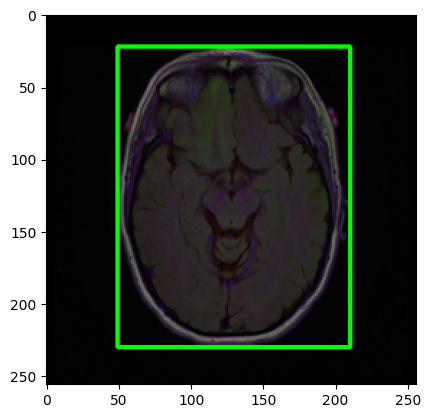

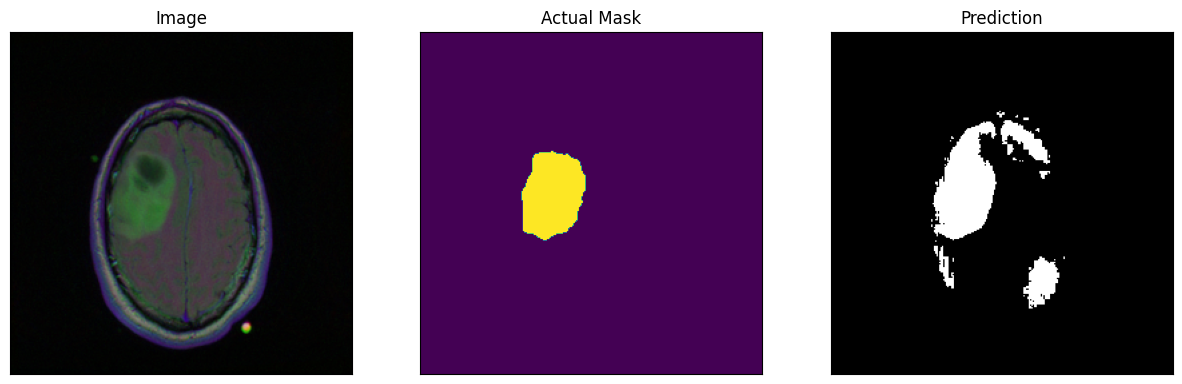

In [49]:
def draw_bounding_box(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(image)

    x_min = x
    x_max = x + w
    y_min = y
    y_max = y + h
    return [x_min, y_min, x_max, y_max]

pr = draw_bounding_box(np.array(test_dataset[10]["image"]))

inputs = processor(image, input_boxes=[[pr]], return_tensors="pt").to(device)

model.eval()
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(np.array(image), cmap='gray')
axes[0].set_title("Image")
axes[1].imshow(ground_truth_mask)
axes[1].set_title("Actual Mask")
axes[2].imshow(medsam_seg, cmap='gray')
axes[2].set_title("Prediction")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()
